# Decision curve analysis or why interpretation of medical decision support models should be based on their potential medical benefit
*Where we explore why decision curve analysis is very powerful metric in a medical context*

# Introduction
Making good diagnostic decisions is key in any medical workflow. The amount of data available to make that decision accurately is growing quickly, which has the potential to improve the decision making process. However, the increase in data often also increases the workload for the medical professional (ref Huisman 2023). Decision support models can ease this workload by synthesizing large amounts of data into more accessible chunks of information. For example, a model could predict the probability a patient has prostate cancer based on a number of characteristics of that patient. The medical professional now only has to deal with a single probability, and not with the intricate patterns and interactions in the patient characteristic data. 

But if we use a model to synthesize our data, the performance of the model should be good. But how do we express this performance? Many measures of performance (metrics) could be used for this, a natural choice would be how often the model returns the correct answer, i.e. the accuracy. However, in medical datasets the data is often unbalanced: the number of cancer patients in the data is much lower than the amount of healthy people. Therefore, a model predicts no one has cancer can still have a very good accuracy. But this high accuracy is not really meaningful as we ignore everyone that actually has cancer. Another alternative are the sensitivity and specificity, i.e. how good the model is at accurately predicting if a person has cancer or not respectively. This allows the researcher to balance the performance of the model for both sick and healthy people. 

So choosing the metric that matches the medical objective of the model is vital. The goal of this article is to introduce a particularly useful metric in a medical context, net benefit ([Vickers and Elkin (2006)](https://pubmed.ncbi.nlm.nih.gov/17099194/), [Vickers et al (2019)](https://pubmed.ncbi.nlm.nih.gov/31592444/)), that allows a close analogue between the metric and medical practice. To provide context we also explore an number of common metrics: accuracy, sensitivity/specifity and AUC. We explore their underlying concepts, and see how net benefit extends on those other metrics. But first we start by introducing the case study that we use to illustrate all of the metrics.

*note that the case study and code in this article is heavliy inspired by [the offical DCA tutorial](https://mskcc-epi-bio.github.io/decisioncurveanalysis/dca-tutorial-python.html). What we added was placing DCA in a relevant statistical context, and explore what makes it work.*

# Our case study


Prostate cancer is a very prevalent disease, which is much more treatable if detected early. Elevated PSA levels in the patient's blood indicate that something might be wrong, but this is not enough to conclusively diagnose prostate cancer. The definitive way to determine prostate cancer is to collect a tissue sample of the prostate via a biopsy. However, the biopsy itself is not without risks so we want to choose wisely whom to give a biopsy or not. In this case study we use the statistical model to predict the probability of cancer, and if the probability is high enough we order a biopsy. As context to the model, we also consider the situation where we biopsy no patients, and we biopsy all patients. For a model to be worthwhile, it should perform better than either of these two options. Note that a fourth option could be to take into account the performance of a doctor, but we do not have this data available in our case study. 

The model returns the probability a patient has cancer, to get a biopsy/no-biopsy decision we need to choose above which probablity of cancer we order a biopsy. This is called the probability threshold, and the process of choosing the threshold is called *model calibration*. If, for example, we choose a threshold of 0.2 we deem a biopsy to be necessary when the risk of cancer is 20% or higher. Using a higher threshold in this case seems unrealistic, any patient that is told that their chance of cancer is 1 in 5 (odds 1:4) would want to have a biopsy to be sure. 

The model uses the age of the patient (`age`), a genetic marker (`marker`) and whether or not there is a family history of cancer (`famhistory`) to predict the probability a patient has cancer. For this historical data we also know which patient had cancer or not (`cancer`). 

In [1]:
import pandas as pd
from helper_functions import *

df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv').drop(columns=['cancerpredmarker', 'risk_group'])
df_cancer_dx.head()

,patientid,cancer,age,famhistory,marker
0,1,0,64.03445,0,0.776309
1,2,0,78.46741,0,0.267086
2,3,0,64.14617,0,0.169621
3,4,0,58.53482,0,0.023996
4,5,0,63.99250,0,0.070910


Note that typically we would split the data into a training and test dataset too prevent overfitting, but to compare the different metrics this is not strictly needed. Therefore, I omitted this step. 

Based on this data we fit a [logistic regression](https://www.ibm.com/topics/logistic-regression) model:

In [2]:
import statsmodels.api as sm

biopsy_model = sm.GLM.from_formula('cancer ~ age + marker + famhistory', data=df_cancer_dx, family=sm.families.Binomial()).fit()
print(biopsy_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cancer   No. Observations:                  750
Model:                            GLM   Df Residuals:                      746
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -213.89
Date:                Wed, 10 Apr 2024   Deviance:                       427.79
Time:                        13:13:24   Pearson chi2:                     743.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2130
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -22.0703      2.211     -9.984      0.0

For this article, it is mainly important to understand the fitted model coefficients. To get nicely interpretable coefficients, we take the exponent of the parameters to transform them to odds:

In [3]:
np.exp(biopsy_model.params)

Intercept     2.600116e-10
age           1.325770e+00
marker        2.660012e+00
famhistory    2.375435e+00
dtype: float64

All these coefficients represent the odds ($\frac{p}{1-p}$) of a patient having cancer:

- `intercept` For a patient with the hypothetical age 0, zero score on the marker and no family history of cancer the odds are almost zero that a patient has cancer.
- `age` for each year the patient is older, the odds of cancer become 1.3 times bigger. 
- `marker` for each unit increase of the marker, the odds of prostate cancer become 2.7 times bigger.
- `famhistory` a family history of prostate cancer increases the likelihood of cancer 2.4 times. 

If we draw a scatterplot of `age` versus `marker` including the decision boundary of probability threshold 0.2 and `famhistory == 1` we see that the model performs quite nicely:

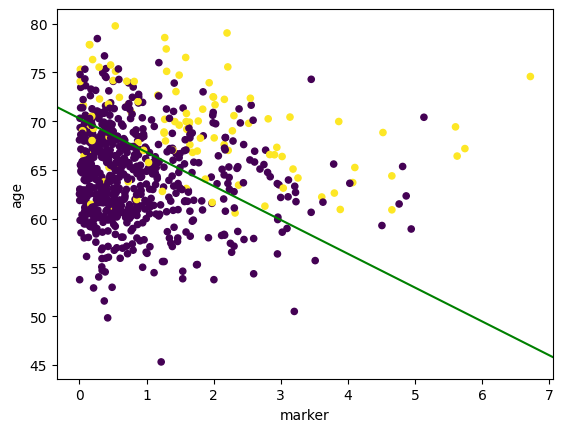

In [4]:
import matplotlib.pyplot as plt

p_thold = 0.2
logit_p = np.log(p_thold / (1 - p_thold))

marker_range = np.linspace(*df_cancer_dx['marker'].agg(['min', 'max']))
ax = df_cancer_dx[['cancer', 'marker', 'age']].plot(kind='scatter', x='marker', y='age', c='cancer', colormap='viridis', colorbar=False)

c_intercept, c_age, c_marker, c_famhistory = biopsy_model.params
marker_range = df_cancer_dx['marker'].agg(['min', 'max'])

famhistory = 1
age_pred = (-c_intercept - c_marker * marker_range - c_famhistory * famhistory + logit_p) / c_age
ax.axline((marker_range[0], age_pred[0]), (marker_range[1], age_pred[1]), color='green', label='famhistory')   

Remember that the data is historic, and contains information if a patient turned out to have cancer or not. The confirmed cancer patients (yellow dots) are generally above the decision line, and the bulk of the healthy people are below the decision line. However, some patients that turned out to have cancer are not classified as such and vice versa. So, the model has predictive power, but is certainly not flawless in deciding who should get a biopsy or not. 

# The building blocks of model evaluation
The figure above shows that choosing the decision boundary is vital. If we set it too low we will catch more people with cancer, but the amount of unecessary biopsy will become very high. So our challenge is to find a metric that will help us choose how to configure our model in such a way that it creates the most medical benefit. 

The building blocks of our metrics are how often the model makes the correct or wrong decision. In the plot above, we have patients with cancer that are not given a biopsy (yellow dots under the line). This is called a False Negative (FN) as we falsely assume that no biopsy is needed. The inverse of that is the False Positive (purple dots above the green line), where based on the model we falsely assume that a biopsy is needed. The model also makes good decisions, in this case True Positives (TP, correctly assign biopsy) and True Negatives (TN, correctly omit biopsy). 

TP, TN, FP and FN form the basis for all of the metrics we discuss in this article. The following figure illustrates them for our dataset:

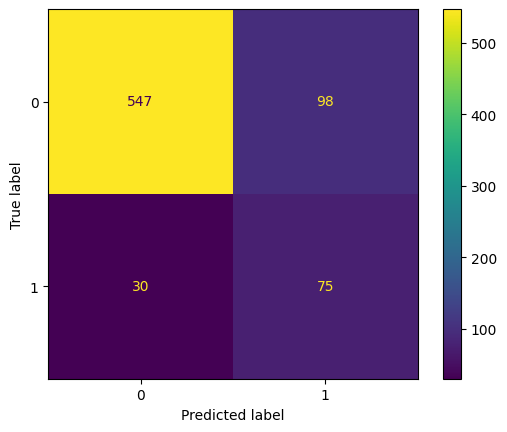

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(df_cancer_dx['cancer'], biopsy_model.predict(df_cancer_dx) >= 0.2)

The counts on the diagnoal are the TP and TN, the off-diagonal counts are FP and FN. 

# The most basic metric: accuracy
For many machine learning applications, accuracy is the most obvious performance metric to use. This is simply defined as the fraction of times the model makes the correct decision:

$$
ACC = \frac{TP + TN}{n_{total} + n_{non-cancer}}
$$

The accuracy of our biopsy model is:

In [6]:
from sklearn.metrics import accuracy_score
thold = 0.2

accuracy_score(biopsy_model.predict(df_cancer_dx[['age', 'marker', 'famhistory']]) >= thold, df_cancer_dx['cancer'])

0.8293333333333334

Which shows that the model makes the correct decision 83% of the time when using a probability threshold of 0.2. For our two other treatment options (biopsy everyone, biopsy no one) we get the following accuracies:

In [7]:
# biopsy everyone
print(accuracy_score(np.ones(len(df_cancer_dx['cancer'])) >= thold, df_cancer_dx['cancer']))
#  biopsy no one
print(accuracy_score(np.zeros(len(df_cancer_dx['cancer'])) >= thold, df_cancer_dx['cancer']))

0.14
0.86


In [8]:
len(df_cancer_dx['cancer']) * 0.14

105.00000000000001

This is an unexpected result: our model seemed to have significant predictive power but the model accuracy is lower then simply giving no one a biopsy (83% versus 86%). This does not make sense, all the cancer patients in the dataset would not get a cancer diagnosis (14%, 105 patients) and suffer massive consequences. But why is accuracy such a poor metric in this case?

Looking at the accuracies for `biopsy-everyone` and `biopsy-no-one` provides a hint as to what is going on: the accuracies are the exact fractions of cancer and non-cancer patients in the dataset. In addition, the number of healthy patients is much larger or in statistical terms: the dataset is unbalanced. By comparing the number of TP+TN versus the *size of the entire dataset* the extremely simple `biopsy-no-one` model can have a very high accuracy. So the accuracy is far too strongly influenced by the imbalance in the dataset to provide a meaningful interpretation of the performance of our model compared to the `biopsy-everyone` and `biopsy-no-one` options. 

# A better metric: Area under curve (AUC)
So, how do we deal with unbalanced datasets? A trick that is often used is to not look at the fraction or rate of good decisions versus the entire dataset, but the fraction of good decisions *per prediction category* (cancer/non-cancer). The two key ones are the True Positive Rate (TPR) and the False Positive Rate (FPR):

- TPR, what fraction of the time does the model predict cancer *when the patient actually has cancer* ($TPR = \frac{TP}{n_{cancer}}$) and thus the biopsy was correctly performed. This is also known as the *sensitivity* of the model. 
- FPR, what fraction of the time does the model predict cancer when the patient actually *does **not** have cancer* ($FPR = \frac{FP}{n_{non-cancer}}$), and the the biopsy was unecessary. This is also know as *one minus the specificity* of the model. 

By separating the performance per category, the performance in detecting cancer (TPR) becomes obvious, whilst in the case of accuracy it was obscured by the massive amount of healthy people. 

As we stated earlier, to make biopsy/no-biopsy decisions we need to pick a decision threshold $\theta$. But how does $\theta$ influence the TPR and FPR? The following plot shows the distribution of probabilities of our biopsy model, with density lines for the cancer and non-cancer patients as in this dataset we have that information. The density lines are comparable to histograms, it shows what fraction of the data has that particular model probability. The black line represents the decision threshold of 0.2, i.e. patients to the right of this line are given a biopsy. From this plot we can see how strongly our model probabilities line up with actual confirmed cases of cancer determined later. 

<Axes: title={'center': 'Biopsy Model'}, xlabel='Probability of model that patient has cancer', ylabel='Density'>

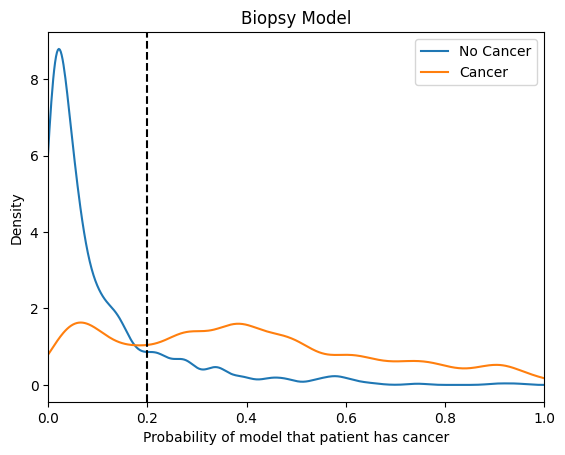

In [13]:
df_cancer_dx['biopsy_prob'] = biopsy_model.predict(df_cancer_dx)
df_cancer_dx['noone_prob'] = np.zeros(len(df_cancer_dx['cancer'])) 
df_cancer_dx['everyone_prob'] = np.ones(len(df_cancer_dx['cancer'])) 

prob_density_plot(df_cancer_dx, y='biopsy_prob', by='cancer', vline=[0.2], title='Biopsy Model', xlabel='Probability of model that patient has cancer')

Important to note in the plot:

- Non-cancer patients overwhelmingly have a low predicted probability of cancer (blue line). Choosing a threshold probabilty of 0.2 means that the True Negative Rate or specificity will be very high. Because of that, the False Positive Rate (unecessary biopsies) will be quite low.
- Cancer patients show a much more broad range of predicted probabilities (orange line), which means that whichever probability threshold we choose the True Positive Rate (accurately assigned biopsies) will never be close to one. 

Here we see there is a tradeoff between the model accurately identifying cancer patients (TPR) and limiting unneeded biopsies (FPR). If we plot the TPR and FPR for different values of the $\theta$ we get a so called Relative Operating Characteristic (ROC) curve. The next figure shows the ROC curves for our three treatment options:

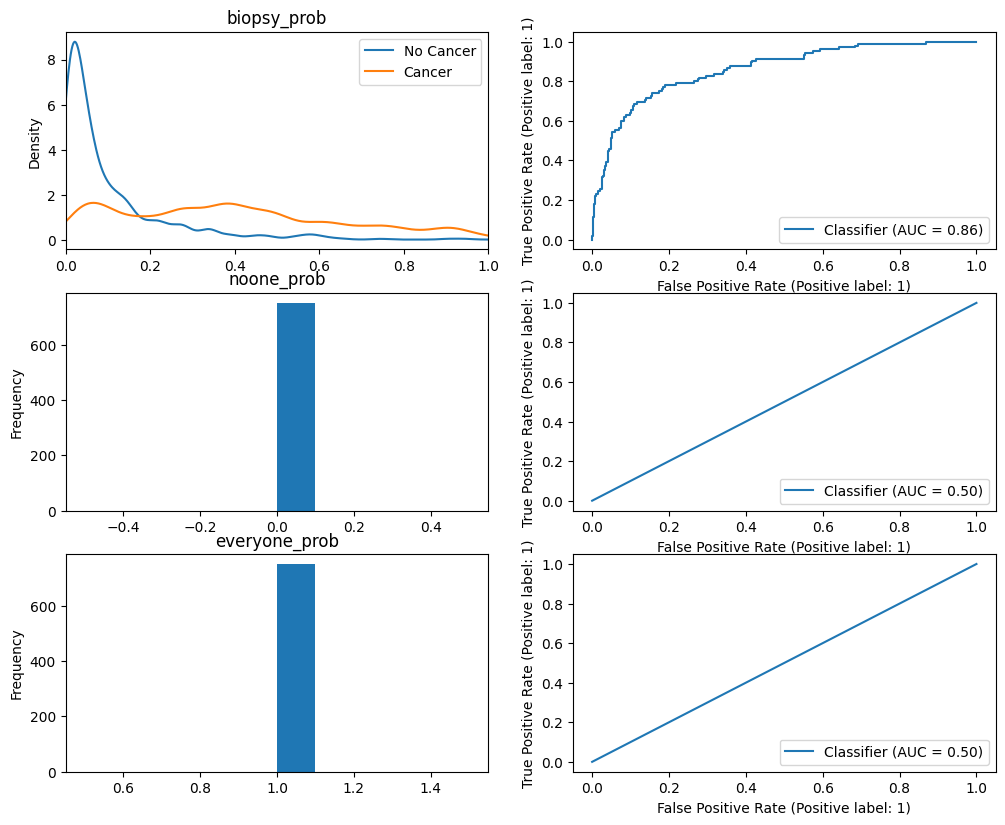

In [10]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(12,13))
base_subplot = 420

for i, col in enumerate(['biopsy_prob', 'noone_prob', 'everyone_prob']):
    roc_pos_offset = (2*(i + 1))
    plt.subplot(base_subplot + roc_pos_offset - 1)
    if col == 'biopsy_prob':
        prob_density_plot(df_cancer_dx, col, 'cancer', title=col, vline=[])
    elif col == 'famhistory_prob':
        df_cancer_dx.groupby('cancer')[col].plot.hist(legend=True, xlim=(0,1), title=col)
    else:
        df_cancer_dx[col].plot(kind='hist', title=col)

    ax = plt.subplot(base_subplot + roc_pos_offset)
    RocCurveDisplay.from_predictions(y_true = df_cancer_dx['cancer'], y_pred = df_cancer_dx[col], ax=ax)

The plots also shows a so called AUC score, this is the area under the ROC curve. The AUC quanitfies the performance of the model over the whole range of possible probability tresholds, in contrast to the accuracy which looks at one particluar decision threshold. A good intuition for the ROC curve is that it measures if the predictions of the model are *ranked* correctly, i.e. it tells you what is the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance ([this link](https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc)).

The lowest value for the AUC is 0.5, which means that the classifier is no better than randomly guessing which patient needs a biopsy or not. Important to note in the figure:

- The ROC curves for the 'biopsy-no-one' and 'biopsy-everyone' show a flat line and an AUC of 0.5. For example for 'biopsy-everyone', all probabilites for all patients are 1. So the TPR for any probability threshold is 1 as all cancer patients are given a biopsy, but the FPR is also 1 as every non-cancer patient also are given a biopsy. The AUC is 0.5, so the 'biopsy-everyone' is no better then randomly choosing whom to biopsy. 
- The ROC curve for the complex model is a lot better, showing the model to be significantly better than randomly assigning biopsies. 

So the AUC is a much better metric that is less sensitive to unbalanced data than accuracy, and this makes it very suitable for evaluating decision (support) models. However, [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/) provides some caveats for using ROC curves and AUC for unbalanced datasets. 

There is still one problem: the AUC judges a detected cancer patient (TP) and an unecessary biopsy (FP) as equally important. That makes no sense for our case study: missing a cancer patient is obviously more harmful then an unecessary biopsy. Next we will look at a metric which address that shortcoming: the net benefit metric from decision curve analysis. 

# Balancing unecessary biopsies and detecting cancer: net benefit
Decision curve analysis introduces a new metric called the *net benefit*. It frames the performance of the model as a cost-benefit analysis. The benefit part of net benefit is derived from how good the model is at accurately assigning biopsies, i.e. the True Positive Rate (TPR, sensitivity). The cost part of the net benefit is derived from how many unecessary biopsies the model suggests, i.e. the False Positive Rate (FPR, 1 - specificity). Note that these are the exact same metrics that the ROC curve and thus the AUC score use. 

The unique addition the net benefit introduces is that we can scale how important a correct biopsy is versus an unnecessary biopsy. This scaling is derived from the decision threshold $\theta$. A $\theta$ of 0.2 means that from a 20% probability of cancer onwards we order a biopsy. This means that we expect for each accuracte biopsy (20% chance) to accept 4 unnecessary biopsies (80% chance). This means an accurate biopsy is 4 times more important, and counts four times more towards the net benefit. This risk discussion is something the resaercher should have with a medical professional. And in our experience, this kind of question is relevant for a clinician. 

The calculation above is for one value of $\theta$, but we can also calculate it for many other values of $\theta$. If we graph $\theta$ versus net benefit, we obtain the titular decision curve. A decision curve analysis contains a curve for each of the decision options (`everyone-biopsy`, `no-one-biopsy`, `model-biopsy`). For our case study we draw the DCA using the `dcurves` package:

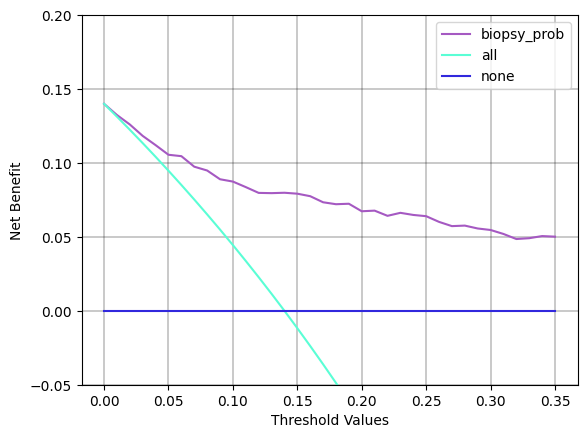

In [11]:
from dcurves import dca, plot_graphs

dca_multi_df = \
    dca(data=df_cancer_dx,
        outcome='cancer',
        modelnames=['biopsy_prob'],
        thresholds=np.arange(0,0.36,0.01))

plot_graphs(plot_df=dca_multi_df,
    y_limits=[-0.05, 0.2],
    graph_type='net_benefit')


In the code above we used a number of settings. `thresholds` is the variable that determines what decision threshold values we are going to explore. We capped this at 0.36 because if the chance of cancer is larger than this, we feel no sane medical professional would *not* schedule a biosy. In addition, we limit the negative part of the y-axis (net benefit), in general a negative net benefit means that this medical decision option is not worth taking, and doing nothing is a better option. So it does not make sense showing that part of the y-axis. For more guidance on configuring the DCA, I recommend [this article](https://www.fharrell.com/post/edca/). 

A number of observations are important in the graph above:

- The biopsy-no-one option (`none`) always shows a net benefit of 0: you never make a mistake, but you also never correctly assign a biopsy. No cost, no benefit. 
- The biopsy-everyone option (`all`) shows good net benefit for lower values of the decision threshold $\theta$. This makes sense, as lower $\theta$ values emphasize giving biopsies to those with cancer (TP). In this lower $\theta$ range, biopsy-everyone is a better option than biopsy-no-one. 
- The biopsy-everyone option (`all`) shows negative net benefit from a $\theta$ of 0.14 onwards. This means that more harm is done by unnecessary biopsies than benefit is gained from giving biopsies to cancer patients. 
- The net benefit of our biopsy model is almost always higher then both of the other options. Only for really low $\theta$ values the biopsy-everyone option becomes viable, as we are willing to accept a lot of unecessary biopsies etiher way. 
- Plotting $\theta$ versus net benefit for all these options shows a more subtle performance distribution than we could observe with both accuracy and AUC. In terms of AUC, the biopsy-no-one and everyone options were completely useless compared to the model. Now we see that the story is a bit more subtle, in extreme case one might even prefer the everyone option. 

# Advantages of net benefit and DCA
After exploring DCA and net benefit more generally, we want to go into more detail how the net benefit is calculated. This will allow us to point out some specific advantages this metric has. Given a decision threshold $\theta$, the net benefit is defined as:

$$NB_{\theta} = TPR_{\theta} \times \frac{n_{cancer}}{n} - FPR_{\theta} \times \frac{n_{non-cancer}}{n} \times \frac{\theta}{1-\theta}$$

where:

- $TPR_{\theta} \times \frac{n_{cancer}}{n}$ is the benefit of the comparison, in this case the fraction of cancer patients in the data that get the biopsy they need.
- $FPR_{\theta} \times \frac{n_{non-cancer}}{n}$ is the cost of the comparison, in this case the fraction of healthy people in the data getting an uneccesary biopsy.
- $\theta$ the decision threshold: how much risk of cancer would warrant a biopsy? Setting this to 0.1 means that when the probability is 10% or higher, we order a biopsy. 
- $\frac{\theta}{1-\theta}$ are the odds that specificy how much more or less important we judge an unecessary biopsy to be, which is linked to the decision threshold. For our previous example of $\theta = 0.2$, this would lead to $\frac{1}{4}$ meaning the unnecessary biopsy is 4 times *less* important than correctly assigning a biopsy. Alternatively, we would accept 4 unnecessary biopsies for each correct biopsy. 

Net benefit shows a number of advantages here in contrast to AUC score. Firstly, it allows us to weigh different types of errors differently (FP vs FN), in this case that a FN (no biopsy for sick person) is worse than FP (unnecessary biopsy). In addition, the decision threshold $\theta$ has a really nice clinical interpretation. How many wrong unnecessary biopsies are you willing to accept for each correctly assign biopsy. This makes it easier to use the decision curve in communicating the worth of a model to a medical professional. These advantages make decision cure analysis and net benefit a strong candidate to be the go-to performance metric for these kinds of decision (support) models. 

# Acknowledgements
*TODO*

# Background information & further reading

- https://www.fharrell.com/post/edca/
- https://mskcc-epi-bio.github.io/decisioncurveanalysis/index.html
- https://mskcc-epi-bio.github.io/decisioncurveanalysis/literature.html
    - [Original paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2577036/)
- [Paper criticizing smote and such, also criticizing accuracy specifically and mentioning decision curve analysis indirectly](https://academic.oup.com/jamia/article/29/9/1525/6605096)
- https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc


- PR ROC is listed as a good alternative by [this link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/) to the auc score for unbalanced data. 
- The beta-f1 score is also an interesting metric
